Importing the necessary libraries we are using in this project

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

Downloading Historical Data from Yahoo Finance

In [16]:
ticker = 'AAPL' 
start_date = '2010-01-01'
end_date = '2023-01-01'

data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


 Data Preprocessing

In [17]:
close_prices = data['Close'].values.reshape(-1, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

#Creating training and test sets
training_data_len = int(np.ceil(len(scaled_data) * 0.8))

train_data = scaled_data[:training_data_len]
test_data = scaled_data[training_data_len - 60:] 

#Creating the sequences for LSTM
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(look_back, len(data)):
        X.append(data[i-look_back:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data)
X_test, y_test = create_dataset(test_data)

#Reshaping the data to be 3D [samples, timesteps, features] for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Building the LSTM Model(Long Short Term Memory)

In [18]:
model = Sequential()

#Adding LSTM layers and some Dropout layers to prevent overfitting
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

#Compiling the model
model.compile(optimizer='adam', loss='mean_squared_error')

c:\Users\TOSHIBA\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training the LSTM model, making predictions and evaluating the model

In [19]:
model.fit(X_train, y_train, batch_size=32, epochs=15)

#Predicting the stock prices using the test data
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

y_test_unscaled = scaler.inverse_transform(y_test.reshape(-1, 1))

#Calculating RMSE(Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions))
print(f'Root Mean Squared Error: {rmse}')

Epoch 1/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 0.0032
Epoch 2/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 81ms/step - loss: 2.9540e-04
Epoch 3/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 2.8869e-04
Epoch 4/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 1.8101e-04
Epoch 5/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - loss: 1.6533e-04
Epoch 6/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 1.8038e-04
Epoch 7/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 1.4234e-04
Epoch 8/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 79ms/step - loss: 1.4830e-04
Epoch 9/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 104ms/step - loss: 1.3964e-04
Epoch 10/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step - loss: 1.3071e-04
Epoch 11/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - loss: 1.2154e-04
Epoch 12/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - loss: 1.2128e-04
Epoch 13/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 1.0171e-04
Epoch 14/15
80/80 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 1.2889e-04
Epoch 15/15
80

Ploting the results

C:\Users\TOSHIBA\AppData\Local\Temp\ipykernel_1688\2565648511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


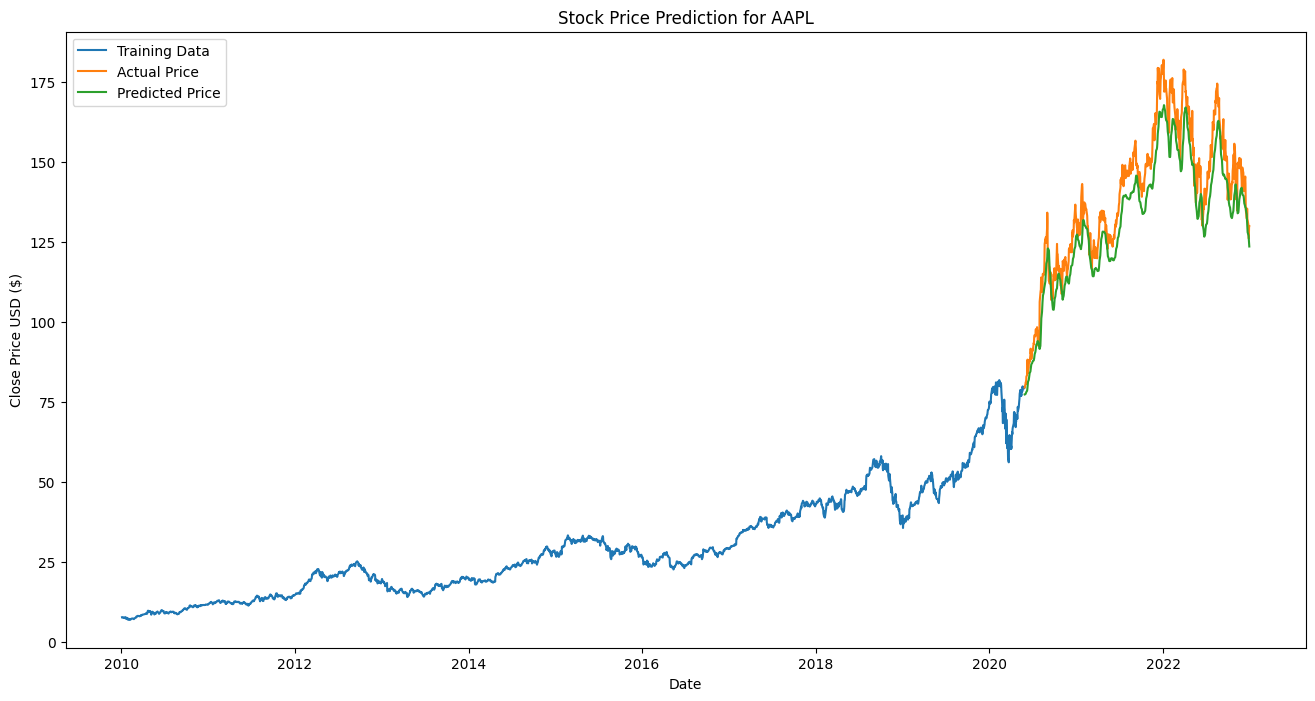

In [20]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title(f'Stock Price Prediction for {ticker}')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'], label='Training Data')
plt.plot(valid[['Close', 'Predictions']], label=['Actual Price', 'Predicted Price'])
plt.legend()
plt.show()

In [21]:
model.save(f'{ticker}_lstm_model.keras')